# Option Pricing Using *rivapy* American Vanilla Specification

In [1]:
from rivapy import marketdata as mkt_data
from rivapy import enums as enums
import datetime as dt
import rivapy
import math
import matplotlib.pyplot as plt
# from scipy.stats import norm
# import random
import pandas as pd

# %load_ext autoreload
# %autoreload 2
# #the next line is a jupyter internal command to show the matplotlib graphs within the notebook
# %matplotlib inline

## Create the necessary market data

As a first step, we need to create the market data necessary to conduct the valuation. Therefore, we need to construct a *discount-*, *funding-* and *borrowing curve*, as well as a *forward-curve* and *volatility surface*.

### Create a discount-, funding-, and borrowing curve

In [2]:
refdate = dt.datetime(2021,1,1,0,0,0)
days_to_maturity = [1, 180, 365, 720, 3*365, 4*365, 10*365]
dates = [refdate + dt.timedelta(days=d) for d in days_to_maturity]
# discount factors from constant rate
disc_rate = 0.05
dc = mkt_data.DiscountCurve("DC", refdate, dates, 
                                            [math.exp(-d/365.0*disc_rate) for d in days_to_maturity])
borrow_rate = 0.02
bc = mkt_data.DiscountCurve("BC", refdate, dates, 
                                            [math.exp(-d/365.0*borrow_rate) for d in days_to_maturity])

funding_rate = 0.05
fc = mkt_data.DiscountCurve("FC", refdate, dates, 
                                            [math.exp(-d/365.0*funding_rate) for d in days_to_maturity])

### Create a dividend table

In [3]:
refdate = dt.datetime(2021,1,1,0,0,0)
ex_dates =  [refdate + dt.timedelta(days=i) for i in [365, 2*365, 3*365, 4*365]]
pay_dates = [d + dt.timedelta(days=2) for d in ex_dates]
tax_factors = [1.0, 1.0, 1.0, 1.0]
div_yield = [0, 0.0, 0.02, 0.02]
div_cash = [2.5, 2.5, 1.5, 1.5]
div_table = mkt_data.DividendTable('DIV', refdate, ex_dates, pay_dates, div_yield, div_cash, tax_factors)

### Create a forward curve

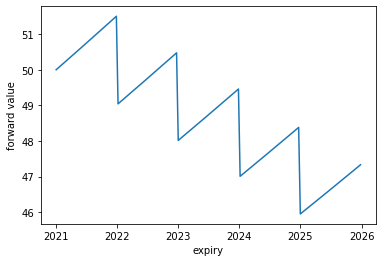

In [4]:
# Creation of a Forward curve
spot = 50.0
forward_curve = mkt_data.EquityForwardCurve(spot, fc, bc, div_table)
forward_curve.plot(days_end=5*365)

### Create a volatility surface

In [5]:
vol_param = mkt_data.VolatilityParametrizationFlat(0.3)
vol_surf = mkt_data.VolatilitySurface('TEST_SURFACE', refdate, forward_curve, enums.DayCounterType.Act365Fixed, vol_param)

### Setup the specification

The rivapy American Vanilla Specification requires the following mandatory arguments:
>- object id (str)
>- type ('CALL','PUT')
>- expiry (datetime)
>- strike (float)

The following arguments must only be set when a market data manager is used to retrieve pricing data automatically from a database:
>- issuer (str)
>- securitization level (str)
>- currency (str)
>- underlying id (str)

The *share ratio* argument is optional and describes the ratio of covered shares of the underlying by a single option contract. The default value is set to 1.0. The argument distinguishing the European Plain Vanilla Option from the American Plain Vanilla Option is the *exercise before ex date* argument, which indicates if option can be exercised within two days before dividend ex-date. The default value is False.

In [14]:
issuer = 'DBK'
seclevel = 'COLLATERALIZED'
currency = 'EUR'
tpe = 'CALL' # Change to 'PUT' if you want to calculate the price of an european put option.
expiry = refdate + dt.timedelta(days=365)
strike = 60
spec = rivapy.instruments.AmericanVanillaSpecification('Test_call', tpe, expiry, strike, 
                                                       issuer = issuer, sec_lvl = seclevel, curr='EUR',udl_id='ADS',
                                                       share_ratio = 1,exercise_before_ex_date = False)

Referring to the Black-76 model, we consequently provided the model already with the the *option type*, the *expiry* $T$ and the *strike price* $K$. Thus, $F_0$, $r$ and $\sigma$ have not been set yet. This data has been defined in the previous steps by creating the necessary market data. The underlying's forward price $F_0$ is provided through the forward curve which is contained in the volatility surface which, of course, also contains the volatility $\sigma$. $r$ is contained in the provided discount curve. 

## Setup the pricing data

In order to price the American Plain Vanilla Option, the *rivapy.pricing.AmericanPdePricingData* must be provided which requires the following arguments:
>- valuation date (datetime)
>- specification
>- discount curve
>- volatility surface
>- pricing request

The following arguments are optional:
>- time steps per year (int) (default = 60)
>- spot steps (int) (default = 200)

In [15]:
prdata = rivapy.pricing.AmericanPdePricingData(val_date = refdate, 
                                           spec = spec, 
                                           discount_curve = dc, 
                                           vol_surface = vol_surf, 
                                           pricing_request=(rivapy.pricing.ResultType.DELTA, 
                                                            rivapy.pricing.ResultType.GAMMA))

## Calculation of an option price using the pyvacon American Vanilla Specification

After all necessary information has been set, the price of the option can be calculated using the *rivapy.pricing.price* function.

In [16]:
price = rivapy.pricing.price(prdata)
price.getPrice()

2.3180994822206444

 ## Plotting the price

## General Remarks

### Implied volatility

Since the volatility in the option pricing formulas cannot be directly observed, one usually works with implied volatilities. Implied volatilities are the volatilities implied by option prices observed in the market. As it is not possible to invert the Black-Scholes-Merton or Black-76 formulas so that the volatility is expressed as a function of the other parameters, one needs to use an interactive search procedure.

---